# Simulated Quantum Random Walks on Citation Networks

#### Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import random
from qiskit.quantum_info import Operator
import pandas as pd

#### Importing and Processing the network 

Here we import our citation network and graph it using the __networkx__ package. 

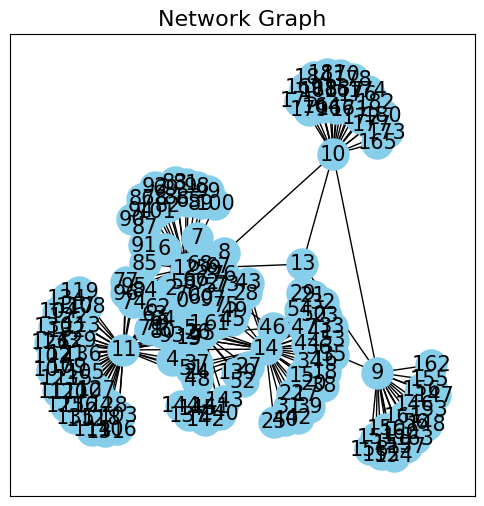

In [2]:

csv_path = "complete_citation_network.csv"  # Replace with your CSV file path
df = pd.read_csv(csv_path)

edges = list(zip(df['Source'], df['Target']))


G = nx.Graph() 
G.add_edges_from(edges)

plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Network Graph", fontsize=16)
plt.show()



#### Preprocessing the network

Given our experiences in the 8 node trial we decided to remove all nodes that had a degree of 1, therefore thatonly had one connection. 

Number of remaining nodes (degree > 1): 51


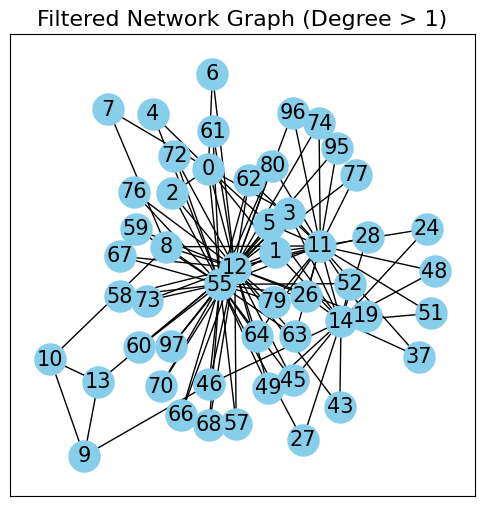

In [3]:
# Remove nodes with degree 1
nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree <= 1]
G.remove_nodes_from(nodes_to_remove)

# Count remaining nodes
num_nodes = G.number_of_nodes()
print(f"Number of remaining nodes (degree > 1): {num_nodes}")



plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Filtered Network Graph (Degree > 1)", fontsize=16)
plt.show()

In addition to eliminating them we need to make sure that the total number of nodes is a power of 2 s we can encode all possible nodes into our circuit. 

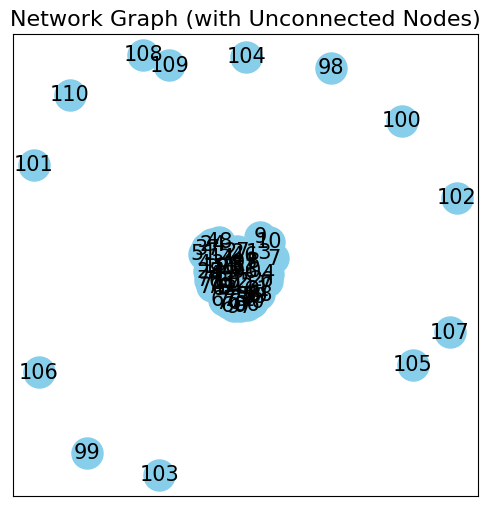

In [4]:
num_nodes = G.number_of_nodes()
additional_nodes_needed = 64 - num_nodes


if additional_nodes_needed > 0:
    # Create a list of new node IDs that do not overlap with existing nodes
    max_node_id = max(G.nodes) if len(G.nodes) > 0 else -1
    new_nodes = range(max_node_id + 1, max_node_id + 1 + additional_nodes_needed)
    G.add_nodes_from(new_nodes)

plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Network Graph (with Unconnected Nodes)", fontsize=16)
plt.show()

In addition to just adding the nodes we want to relabel them from 0 to 63 in this case so we can have an easier time of reading the results of the quantum random walk

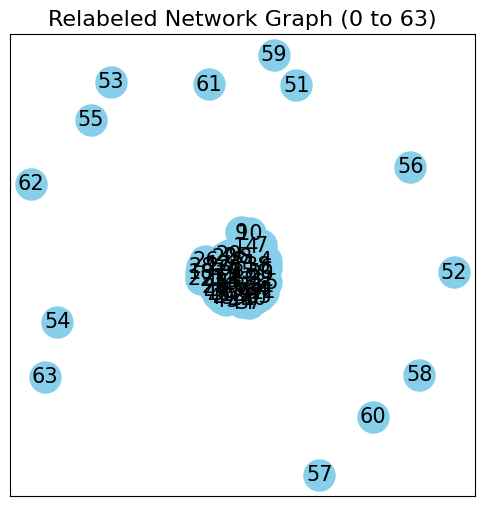

In [5]:
old_to_new_mapping = {old_id: new_id for new_id, old_id in enumerate(G.nodes())}
G = nx.relabel_nodes(G, old_to_new_mapping)

mapping_table = pd.DataFrame(list(old_to_new_mapping.items()), columns=["Old ID", "New ID"])


plt.figure(figsize=(6, 6))
nx.draw_networkx(G, with_labels=True, node_color='skyblue', node_size=500, font_size=15)
plt.title("Relabeled Network Graph (0 to 63)", fontsize=16)
plt.show()


Given our relabeling we will store a concordance table between new and old nodes in a CSV.

In [6]:
print(mapping_table)
# Save the mapping table to a CSV file
mapping_table.to_csv("node_mapping_table.csv", index=False)
print("Mapping table saved to 'node_mapping_table.csv'.")


    Old ID  New ID
0        1       0
1        0       1
2        2       2
3        3       3
4        4       4
..     ...     ...
59     106      59
60     107      60
61     108      61
62     109      62
63     110      63

[64 rows x 2 columns]
Mapping table saved to 'node_mapping_table.csv'.


Having completed all the preprocessing we can now produce our Adjacency matrix

In [7]:

adj_matrix = nx.adjacency_matrix(G).toarray()
print("Adjacency Matrix:")
print(adj_matrix)


A = adj_matrix.astype(float)

Adjacency Matrix:
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Creating our quantum walk

The following functions will allow us to create our quantum walk for different time points in a reusable manner. 

In [8]:

def quantum_walk_t(A,t,n:int): 
    """
    Creates a quantum circuit for a quantum random walk at a specific time t starting at node n

    """
    # Intialize a quantum circuit
    num_target_qubits = int(np.log2(A.shape[0]))  # Infer target qubits from A
    qc = QuantumCircuit(num_target_qubits)  

    # Convert n to binary
    binary= format(n, f'0{num_target_qubits}b')
    
    # Encode starting node 
    for i, bit in enumerate(reversed(binary)):  # Reverse to match Qiskit's qubit indexing
        if bit == '1':
            qc.x(i)

    # Calculate e^{-iAt}
    i = complex(0, 1)
    U_minus = expm(-i * A * t)  # e^{-iAt}

    qc.unitary(Operator(U_minus), range(num_target_qubits))

    qc.measure_all()

    return qc

def measure_quantum_circuit(qc, simulator: str):
    """
        Runs a simulation of a quantum circuit and returns counts at that point
    """ 
    sim = Aer.get_backend(simulator) 
    result = sim.run(qc).result()
    counts = result.get_counts()
    return counts

def add_max_and_avg(df):
    """
    Adds a row with the maximum value of each column (P-max) and the average of each column (P-avg).
    """
    # Find max values for each column ( node)
    p_max = df.drop('Time', axis=1).max()
    
    # Find average values for each column ( node)
    p_avg = df.drop('Time', axis=1).mean()

    # Add to dataframe
    df.loc[len(df)] = ['P-max'] + p_max.tolist()
    df.loc[len(df)] = ['P-avg'] + p_avg.tolist()
    
    return df

#### Trial with one walk starting at node 9

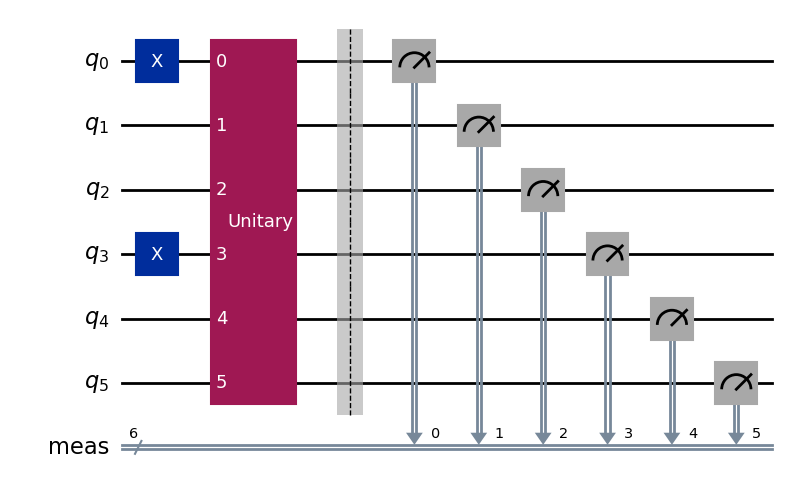

In [9]:
qc = quantum_walk_t(A, 0, 9)
qc.draw("mpl")

#### Simulated Quantum Random Walk

Here we run the entire walk and store its results on CSV. This walk was performed only on a simulator

In [ ]:
possible_nodes = [f'{i:06b}' for i in range(64)]

columns = ['Time'] + possible_nodes
results_df = pd.DataFrame(columns=columns)

# Loop through the times and simulate the quantum walk
for i in np.arange(0, 10, 0.5):  # Change range as needed especially the end time and the steps
    qc = quantum_walk_t(A, i, 9)
    counts = measure_quantum_circuit(qc, 'aer_simulator')

    # Ensure all possible nodes are represented, even if they have a count of 0
    for node in possible_nodes:
        if node not in counts:
            counts[node] = 0

    shots = 1024  # Total number of shots used by simulator
    probabilities = {key: value / shots for key, value in counts.items()} # dividing by total shots to get probability

    # Saving results to DataFrame
    row = [i] + [probabilities.get(node, 0) for node in possible_nodes]  # Ensure 0 if key not found
    results_df.loc[len(results_df)] = row

# Print the results DataFrame

add_max_and_avg(results_df)
print(results_df)
results_df.to_csv("resultstrial2-9.csv", index=False)



     Time    000000    000001    000010    000011    000100    000101  \
0     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.5  0.000977  0.001953  0.000977  0.000000  0.000000  0.000977   
2     1.0  0.000000  0.004883  0.000000  0.000000  0.001953  0.000000   
3     1.5  0.000977  0.005859  0.000977  0.005859  0.020508  0.001953   
4     2.0  0.004883  0.000000  0.002930  0.004883  0.016602  0.007812   
5     2.5  0.001953  0.005859  0.003906  0.005859  0.001953  0.002930   
6     3.0  0.000000  0.008789  0.000000  0.003906  0.005859  0.000977   
7     3.5  0.000000  0.002930  0.000000  0.000000  0.004883  0.000000   
8     4.0  0.000000  0.009766  0.000000  0.000000  0.000977  0.000000   
9     4.5  0.003906  0.023438  0.002930  0.002930  0.002930  0.004883   
10    5.0  0.008789  0.000977  0.017578  0.008789  0.021484  0.009766   
11    5.5  0.007812  0.037109  0.006836  0.010742  0.017578  0.004883   
12    6.0  0.001953  0.045898  0.002930  0.000977  

#### Explanation of hardware

This walk was only done on simulators because and assembled qalk for 64 nodes at any tie , except 0, would generate  17,000- 20,000 gates as evidenced by the following code. Given that even the best IBM processors today can only handle 3,000 gates we can understand why this is an impossibility at the moment but our simulator and 8-node trials give indications of where we will be in som e years - decades time.

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

 
QiskitRuntimeService.save_account(
  token= "",
  channel="ibm_quantum",
  overwrite='true'
)

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

In [12]:
qc = quantum_walk_t(A, 1, 9)
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
assembled_circuit = pm.run(qc)
print(assembled_circuit.depth())

19705
